In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
pickup_data = pd.read_pickle('arrival_and_dropoff_distributions')
hourly_arrival_rate =  pickup_data.apply(lambda item: item[0])
dropoff_frequency  = pickup_data.apply(lambda  item: item[1] / item[1].sum())
trip_time_data = pd.read_csv('trip_time_means.csv', index_col = 'pulocationid')
trip_time_data.columns = trip_time_data.columns.astype(int)

In [3]:
trip_time_data

,1,2,3,4,5,6,7,8,9,10,...,254,255,256,257,258,259,260,261,262,263
pulocationid,,,,,,,,,,,,,,,,,,,,,
1,19.037500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,54.540476,NaN,5.167347,43.009259,NaN,NaN,26.164216,NaN,21.255556,28.980556,...,8.283445,36.853333,50.141667,NaN,29.909524,12.957595,25.814583,36.427778,29.962821,31.922222
4,38.440143,NaN,36.005556,8.353476,39.816667,30.175000,25.623986,NaN,32.711111,34.955556,...,32.131944,17.887951,15.287944,21.346354,38.314286,31.405556,22.180637,14.926667,17.628817,18.310448
5,26.337016,NaN,NaN,NaN,6.377981,26.475439,NaN,NaN,NaN,63.383333,...,NaN,41.983333,NaN,NaN,NaN,NaN,NaN,45.066667,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,51.784091,NaN,13.075407,41.887500,NaN,NaN,25.589524,NaN,NaN,34.687500,...,7.817611,38.598958,41.022222,66.283333,45.880392,5.406855,30.971930,50.381818,29.982639,29.974074
260,50.356373,NaN,29.951515,24.593915,NaN,NaN,9.541995,12.531944,21.596930,27.229938,...,28.170290,16.476681,17.322406,29.064583,26.097162,28.320238,6.141669,31.753922,23.707520,23.136458
261,38.053702,NaN,39.591667,14.067819,38.878571,22.952083,29.628744,NaN,35.214583,51.258974,...,39.840000,23.663167,21.626105,17.425219,40.557500,48.560000,26.953968,10.799706,22.717876,23.064069


In [4]:
from tqdm import tqdm

def generate_arrivals_per_zone(zone_hourly_arrivals = hourly_arrival_rate, 
                               zone_dropoff_frequencies = dropoff_frequency, 
                               zone_to_zone_times = trip_time_data, 
                               one_list = True):
    
    #check to make sure the indices match
    assert (zone_hourly_arrivals.index == zone_dropoff_frequencies.index).all()
    assert (zone_hourly_arrivals.index == zone_to_zone_times.index).all()
    
    zone_arrivals = []
    #for each zone, generate a day's worth of arrivals
    for i in tqdm(zone_hourly_arrivals.index):
        
        hourly_rates = zone_hourly_arrivals.loc[i]
        dropoff_dist = zone_dropoff_frequencies.loc[i]
        zone_service_times = zone_to_zone_times.loc[i]
                
        max_rate = hourly_rates.max()
        #rate = max_rate / 60 minutes (since max_rate is in minutes)
        #input the inverse as the mean interarrival time (scale parameter for np.random.exponential)
        temp_interarrivals = np.random.exponential(scale = 60/max_rate, size = 25000)
        
        #this cuts off interarrivals at 1 day
        interarrivals = temp_interarrivals[temp_interarrivals.cumsum() <= 24*60]
        arrivals = interarrivals.cumsum()
                
        #thinning process
        #uses constant hourly rate (like a 24 part step function) to generate the thinning probabilities
        keep_probability = (hourly_rates[(arrivals // 60).astype(int)] / max_rate).values
        unif = np.random.uniform(size = arrivals.shape[0])
        kept_arrivals = arrivals[unif <= keep_probability]
                
        #for each arrival generate from the dropoff distribution
        dropoffs = np.random.choice(dropoff_dist.index, size = kept_arrivals.shape[0], p = dropoff_dist)
                              
        #generate data in the form of (time, dropoff location id, pickup location id)
        arrival_data = np.vstack([kept_arrivals, dropoffs, i*np.ones(kept_arrivals.shape[0])]).T
        
        #format into dataframe
        arrival_df = pd.DataFrame(data = arrival_data, columns = ['time','dolocationid','pulocationid'])
        
        #each arrival, generate a service time from the service time distributions
        #this is SLOW
        services = [np.random.exponential(mean) for mean in zone_service_times[arrival_df.dolocationid]]
                
        arrival_df['service'] = services
        
        zone_arrivals.append(arrival_df)
    
    #if one list, then combine everything into one big arrival matrix
    #otherwise, just return the list of arrival dataframes
    if one_list:
        zone_arrivals = pd.concat(zone_arrivals).sort_values('time').reset_index(drop=True)
    
    return zone_arrivals

In [5]:
arrivals = generate_arrivals_per_zone()

100%|████████████████████████████████████████| 259/259 [00:01<00:00, 131.96it/s]


In [6]:
arrivals

,time,dolocationid,pulocationid,service
0,0.005127,226.0,146.0,10.616757
1,0.013331,246.0,68.0,1.494047
2,0.017344,136.0,208.0,9.029055
3,0.020387,168.0,78.0,19.317561
4,0.026404,36.0,190.0,18.095628
...,...,...,...,...
455307,1439.986808,133.0,190.0,11.772911
455308,1439.991231,231.0,87.0,0.600710
455309,1439.991664,249.0,90.0,14.404124
455310,1439.994975,76.0,216.0,15.189878


In [45]:
def insert_event(event, event_list):
    
    time = event[1]
    
    i = 0
    for e in event_list:
        i += 1
        if time >= e[1]:
            break
    
    event_list.insert(i, event)
    
def simulate_driver_movements(arrivals, 
                              driver_distribution = 'proportional',
                              driver_count = 10000,
                              zone_to_zone_times = trip_time_data):
    
    #event list idea
    #start with all of the arrivals
    #for each arrival, generate a "finished trip" event
    #if an arrival is added to a queue, generate a "driver movement" event where a random driver is selected to serve the
    #queued customer
    
    #also maybe keep track of queues for each zone (just a list of list of pickup ids)
    
    #how to represent an event?
    # (passenger id/driver == -1, time_of_event, dropoff_location, pickup_location, service time, arrival/departure)
    # (int/-1, time, int, int, 0 for departure event/positive for others, 0 for arrival/1 for departure)
    
    
    #np.c_[A,b] appends a column b to matrix A
    event_list = list(np.c_[arrivals.reset_index().values, np.zeros(arrivals.shape[0])])
    passenger_departure_times = {} #id:wait time
    queues = {i:[] for i in np.arange(1,264)}
    
    #record queue state every hour
    queue_states = []
    
    #driver distribution (how many drivers in each zone)
    ddist = None
    
    #assign drivers based on pickup frequencies (could do other options)
    if driver_distribution == 'proportional':
        #get pickup proportions (% of pickups in each region)
        props = arrivals.groupby('pulocationid')['time'].count() / arrivals.shape[0]
        
        #distribute drivers based on proportions
        ddist = pd.Series(data = np.zeros(263), index = np.arange(1,264))
        ddist = ddist.add(np.round(driver_count * props).astype(int), fill_value = 0)
        
        #add remaining drivers to the most popular zone
        m = ddist.idxmax()
        ddist.update({m: ddist[m] + (driver_count - ddist.sum())})
    
    #iterate through event list
    #pbar is just a progress bar that increments when a customer leaves the system
    pbar = tqdm(total = len(event_list), position = 0, leave = True)
    while len(event_list) > 0:
            
        #remove from event list
        event = event_list.pop(0)
        
        #for interpretation purposes
        person = int(event[0])
        time = event[1]
        dropoff = int(event[2])
        pickup = int(event[3])
        service_time = event[4]
        arr_dep = int(event[5])
        
        #every hour, add to the queue state
        if len(queue_states) < time // 60:
            queue_states.append([time, queues])
        
        #if passenger
        if person > -1:
            #if arrival
            if arr_dep == 0:
                #if a driver is free in the pickup zone, generate departure event and remove that driver
                if ddist.loc[pickup] > 0:
                    ddist.update({pickup: ddist.loc[pickup] - 1})
                    
                    insert_event(np.array([person, 
                                            time + service_time, 
                                            dropoff, 
                                            pickup, 
                                            0,
                                            1]), event_list)
                    
                #if a driver is not free, add the person to the queue corresponding to the pickup location
                #generate a driver movement event from a random free driver to come to this zone
                #could also choose the closest driver using the mean travel time between zones
                else:
                    queues[pickup].append(person)
                    
                    free_drivers = ddist[(ddist > 0) & (~zone_to_zone_times[pickup].isnull())]
                    
                    #2 problems here
                    #cant take any random driver bc some of the entries in the loc -> loc matrix are missing
                    #also if there are no free drivers this method fails
                    
                    driver_zone = np.random.choice(free_drivers.index, p = free_drivers / free_drivers.sum())
                    
                    ddist.update({driver_zone: ddist.loc[driver_zone] - 1})
                    
                    #movement time from zone to zone
                    move_time = np.random.exponential(zone_to_zone_times.loc[driver_zone, pickup])
                    
                    insert_event(np.array([-1,
                                           time + move_time,
                                           pickup,
                                           driver_zone,
                                           0,
                                           0]), event_list)
                    
            
            #if departure (finished trip)
            else:
                
                #add the customer's departure time to results
                passenger_departure_times[person] = time
                
                pbar.update(1)
                
                #if a customer is waiting in the dropoff zone, generate a departure event for that customer
                #remove them from the queue in that dropoff zone
                #and remove 1 from ddist
                if len(queues[dropoff]) > 0:                    
                    next_customer = queues[dropoff].pop(0)
                    cust_info = arrivals.loc[next_customer]
                    
                    insert_event(np.array([next_customer,
                                             time + cust_info.service,
                                             cust_info.dolocationid,
                                             cust_info.pulocationid,
                                             0,
                                             1]), event_list)
                
                #if there's no customer waiting just leave the driver
                else:
                    #add 1 to driver distribution at the dropoff location
                    ddist.update({dropoff: ddist.loc[dropoff] + 1})
                
        
        #if driver event, that means its a driver movement from zone to zone
        else:
            #if there is a customer in the zone the driver moves to, pop the customer off the queue
            #and add a departure event
            if len(queues[dropoff]) > 0:
                next_customer = queues[dropoff].pop(0)
                cust_info = arrivals.loc[next_customer]
                
                insert_event(np.array([next_customer,
                                            time + cust_info.service,
                                            cust_info.dolocationid,
                                            cust_info.pulocationid,
                                            0,
                                            1]), event_list)
                
            #if no customer at the end of a driver movement, leave them in the zone
            else:                   
                #add 1 to driver distribution at the dropoff location
                ddist.update({dropoff: ddist.loc[dropoff] + 1})
                    
    pbar.close()
    return passenger_departure_times, queue_states

In [47]:
customer_departures = simulate_driver_movements(arrivals, driver_count = 500)

  3%|█                                  | 13622/455312 [00:31<17:14, 426.93it/s]

ValueError: 'a' cannot be empty unless no samples are taken

  3%|█                                  | 13647/455312 [00:51<17:14, 426.93it/s]

In [27]:
wait_times = (pd.Series(customer_departures[0]).sort_index() - arrivals.time - arrivals.service).round(3)

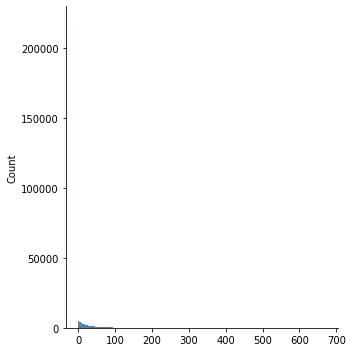

In [33]:
import seaborn as sns

sns.displot(wait_times)